In [1]:
from __future__ import print_function
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
np.random.seed(1337)  # for reproducibility
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, BatchNormalization
from keras.layers import LSTM, SimpleRNN, GRU
from keras.datasets import imdb
from keras.utils.np_utils import to_categorical
from sklearn.metrics import (precision_score, recall_score,f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
from sklearn import metrics
from sklearn.preprocessing import Normalizer
import h5py
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Import xgboost
import xgboost as xgb
from matplotlib import pyplot


import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(
        target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    # Regression
    return df[result].values.astype(np.float32), df[[target]].values.astype(np.float32)

Using TensorFlow backend.


In [2]:
traindata = pd.read_csv('KDDTrain+.csv', header=None)
testdata = pd.read_csv('KDDTest+.csv', header=None)


columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'class',
    'difficulty_level'
]
traindata.columns=columns
testdata.columns=columns

del traindata["difficulty_level"]
del testdata["difficulty_level"]
#traindata.info()
#testdata.info()
trainlen=traindata.shape[0]

alldata=pd.concat([traindata, testdata], axis=0, join='outer',ignore_index=True)
#print(alldata)
#print(alldata['protocol_type'])
#class_names=alldata['class'].unique()
#print(class_names)

mask = alldata['class'] != 'normal' 
alldata.loc[mask, 'class'] = 'attack'

class_names=alldata['class'].unique()
print(class_names)
#alldata.head()


#traindata.info()
#traindata.describe()
protocol_type_dummy=pd.get_dummies(alldata['protocol_type'])
alldata=pd.concat([alldata,protocol_type_dummy],axis=1)
del alldata['protocol_type']


service_dummy=pd.get_dummies(alldata["service"])
alldata=pd.concat([alldata,service_dummy],axis=1)
del alldata["service"]

flag_dummy=pd.get_dummies(alldata["flag"])
alldata=pd.concat([alldata,flag_dummy],axis=1)
del alldata["flag"]
#del alldata["dst_host_diff_srv_rate"]
#del alldata["dst_host_same_src_port_rate"]
#del alldata["dst_host_srv_diff_host_rate"]
#del alldata["dst_host_serror_rate"]
#del alldata["dst_host_srv_serror_rate"]
#del alldata["duration"]
#del alldata["dst_bytes"]
#del alldata["src_bytes"]
#del alldata["wrong_fragment"]
#del alldata["urgent"]
#del alldata["hot"]
#del alldata["num_file_creations"]
#del alldata["num_access_files"]
#del alldata["num_shells"]
#del alldata["num_outbound_cmds"]
#del alldata["is_host_login"]
#del alldata["is_guest_login"]
#del alldata["count"]
#del alldata["srv_count"]
#del alldata["serror_rate"]
#del alldata["srv_serror_rate"]
#del alldata["rerror_rate"]
#del alldata["srv_rerror_rate"]
  
#print(alldata.head())

#print(protocol_type_dummy)

#encode_text_index(alldata, 'class')
alldata["class"] = LabelEncoder().fit_transform(alldata["class"])

# Break into X (predictors) & y (prediction)
#x, y = to_xy(alldata,'class')


#X = alldata.drop('class', axis=1)
#Y = alldata[['class']]
#scaler = Normalizer().fit(alldata.iloc[:,:-1])
#trainX = scaler.transform(alldata.iloc[:,:-1])
# summarize transformed data
#np.set_printoptions(precision=3)
#print(trainX[0:5,:])

#print("trainX:",trainX)

traindata=alldata.ix[0:trainlen-1,:]
testdata=alldata.ix[trainlen:alldata.shape[0],:]

print(traindata['class'].value_counts())
print(testdata['class'].value_counts())


testdata.info()
# Create arrays for the features and the target: 
#X_train, y_train = traindata.iloc[:,:-1], traindata.iloc[:,-1]
#X_test, y_test = testdata.iloc[:,:-1], testdata.iloc[:,-1]

y_train = traindata["class"]
y_test = testdata["class"]
X_train = traindata.drop('class', axis=1)
X_test = testdata.drop('class',axis=1)


print("y_train",np.unique(y_train,return_counts=True))
print("y_test",np.unique(y_test,return_counts=True))



['normal' 'attack']
1    67343
0    58630
Name: class, dtype: int64
0    12833
1     9710
Name: class, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22543 entries, 125973 to 148515
Columns: 123 entries, duration to SH
dtypes: float64(15), int64(24), uint8(84)
memory usage: 8.5 MB
y_train (array([0, 1]), array([58630, 67343]))
y_test (array([0, 1]), array([12833,  9710]))


/home/dsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:132: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/dsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


TIME BEGIN: 2019-09-25 14:43:41.444455
accuracy: 0.786408
[2.5760445e-03 1.6294181e-01 2.8126346e-02 0.0000000e+00 2.2239548e-03
 0.0000000e+00 5.2676544e-02 5.6127021e-03 2.7384388e-04 3.7177345e-03
 2.3380977e-04 0.0000000e+00 3.3258522e-04 4.1830419e-03 0.0000000e+00
 1.5323494e-03 0.0000000e+00 0.0000000e+00 2.4665499e-02 1.9693073e-02
 1.3270585e-03 1.3404934e-03 2.9690256e-03 1.6031144e-03 3.7020439e-04
 1.3139127e-03 5.1050138e-04 7.5941137e-04 8.2168984e-04 1.0054725e-02
 3.0804463e-02 2.5907813e-03 1.8933913e-02 4.4838535e-03 6.6304905e-03
 9.2269909e-03 8.4034372e-03 2.0043256e-03 1.1729187e-02 2.7106050e-04
 1.4327113e-04 1.2090540e-03 5.2285951e-04 0.0000000e+00 0.0000000e+00
 2.0899503e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.7587782e-03 0.0000000e+00
 3.5313838e-03 3.0276126e-01 0.0000000e+00 0.0000000e+00 1.2407980e-03
 1.1280989e-03 6.4545125e-03 0.0000000e+00 0.0000000e+00 0.0000000e+00
 2.2668844e-01 0.00

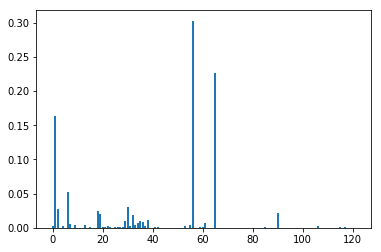

TIME END: 2019-09-25 14:44:11.199665


In [86]:
import datetime
print("TIME BEGIN:",datetime.datetime.now())
# Instantiate the XGBClassifier: xg_cl
#xg_cl =xgb.XGBClassifier(max_depth=12,subsample=0.33,objective='binary:logistic',n_estimators=10,learning_rate = 0.01)
#xg_cl =xgb.XGBClassifier(objective='binary:logistic',, n_estimators=10, learning_rate=0.5,seed=123)
xg_cl=xgb.XGBClassifier(objective='binary:logistic',learning_rate=0.9,seed=0)

# Fit the classifier to the training set
xg_cl.fit(X_train,y_train)

# Predict the labels of the test set: preds
preds = xg_cl.predict(X_test)

# Compute the accuracy: accuracy
accuracy = float(np.sum(preds==y_test))/y_test.shape[0]
print("accuracy: %f" % (accuracy))

print(xg_cl.feature_importances_)

# plot
pyplot.bar(range(len(xg_cl.feature_importances_)), xg_cl.feature_importances_)
pyplot.show()

#print("y_test-",np.unique(y_test,return_counts=True))
print("TIME END:",datetime.datetime.now())

In [87]:
from sklearn.metrics import accuracy_score
accuracy2 = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy2 * 100.0))

Accuracy: 78.64%


In [88]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      0.65      0.77     12833
           1       0.68      0.97      0.80      9710

    accuracy                           0.79     22543
   macro avg       0.82      0.81      0.79     22543
weighted avg       0.84      0.79      0.78     22543



In [89]:
from sklearn.metrics import f1_score
metrics.f1_score(y_test, preds, labels=np.unique(preds))




0.7967754189000971

In [90]:
print("preds-",np.unique(preds,return_counts=True))
print("y_test-",np.unique(y_test,return_counts=True))

preds- (array([0, 1]), array([ 8560, 13983]))
y_test- (array([0, 1]), array([12833,  9710]))


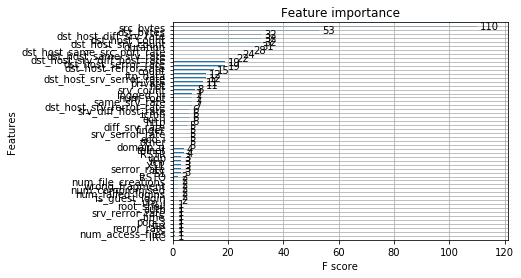

In [91]:
from xgboost import plot_importance

plot_importance(xg_cl)
pyplot.show()

In [92]:
from sklearn.feature_selection import SelectFromModel
selection = SelectFromModel(xg_cl, threshold=0.3, prefit=True)
selected_dataset = selection.transform(X_test)
print(selected_dataset)

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [93]:
results=pd.DataFrame()
results['columns']=X_train.columns
results['importances'] = xg_cl.feature_importances_
results.sort_values(by='importances',ascending=False,inplace=True)

results[:20]

,columns,importances
56,ecr_i,0.302761
65,http,0.226688
1,src_bytes,0.162942
6,hot,0.052677
30,dst_host_same_srv_rate,0.030804
2,dst_bytes,0.028126
18,is_guest_login,0.024665
90,private,0.022009
19,count,0.019693
32,dst_host_same_src_port_rate,0.018934


In [94]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,preds)

array([[8289, 4544],
       [ 271, 9439]])

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test,preds).ravel()
print(tn)
print(fp)
print(fn)
print(tp)

In [28]:
y_train.shape

(125973,)